In [1]:
import torch
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time
from torch.optim import lr_scheduler
import copy

# Data Prep

In [3]:
# define custom dataset
class MyDataset(Dataset):
    def __init__(self, feature, target=None, transform=None):

        self.X = feature
        self.Y = target
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform is not None:
            return self.transform(self.X[idx]), self.Y[idx]
        elif self.Y is None:
            return [self.X[idx]]
        return self.X[idx], self.Y[idx]

In [4]:
data = pd.read_csv("A_Z_Handwritten_Data.csv")
X, y = data.drop('0', axis=1), data['0']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
normalized_X_train = X_train / 255.0

train_split, validation_split, train_y_split, validation_y_split = train_test_split(normalized_X_train, y_train, random_state=0)

In [6]:
X_train = torch.from_numpy(train_split.values.reshape((-1, 1, 28, 28)))
y_train = torch.from_numpy(train_y_split.values)

X_valid = torch.from_numpy(validation_split.values.reshape((-1, 1, 28, 28)))
y_valid = torch.from_numpy(validation_y_split.values)

X_train_set = MyDataset(X_train.float(), y_train)
X_valid_set = MyDataset(X_valid.float(), y_valid)
batch_size = 128

train_loader = torch.utils.data.DataLoader(X_train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(X_valid_set, batch_size=batch_size, shuffle=True)

# Data Augmentation

In [7]:
# calculate mean and std of train_set for normalize
data = next(iter(train_loader))
mean = data[0].mean()
std = data[0].std()

# set transformation option
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees = 30),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

# augmented train_set
augmented_train_set = MyDataset(X_train.float(), y_train, transform=transform)

# combine original set with augmented set
datasets = []
datasets.append(X_train_set)
datasets.append(augmented_train_set)
train_set = torch.utils.data.ConcatDataset(datasets)

# redefine train_loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

# Train Method

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(X_train_set), 'val': len(X_valid_set)}

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

NameError: name 'train_loader' is not defined

# Training

In [ ]:
epochs = 20

# make resnet 18 model
model_ft = models.resnet18(pretrained=False)

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 26)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=epochs)

# Test

In [6]:
device = torch.device("cpu")
model = torch.load("alphabets.pkl", map_location=device)

In [7]:
X_test_adjusted = torch.from_numpy(X_test.values.reshape((-1, 1, 28, 28))).float().to(device) / 255.0
y_test_adjusted = torch.from_numpy(y_test.values).to(device)

In [8]:
with torch.no_grad():
    model.eval()
    preds_test = model(X_test_adjusted)

In [9]:
preds = preds_test.argmax(axis=1)
accuracy = torch.where(preds == y_test_adjusted, 1, 0).float().mean()
accuracy

tensor(0.9949)

In [21]:
_, preds_2 = torch.max(preds_test, 1)
accuracy_2 = torch.where(preds_2 == y_test_adjusted, 1, 0).float().mean()
accuracy_2

tensor(0.9949)

In [10]:
import matplotlib.pyplot as plt
import random
import cv2

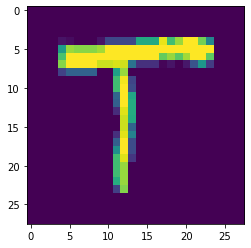

Detected: T


error: OpenCV(4.5.5) /io/opencv/modules/highgui/src/precomp.hpp:155: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


In [12]:
idx = random.randint(0, len(preds))
test_img = torch.from_numpy(X_test.iloc[idx].to_numpy()).to(torch.float64).reshape((28, 28, 1))
plt.imshow(test_img)
plt.show()
print(f"Detected: {chr(ord('A') + preds[idx])}")

#cv2.imshow('img', X_test.iloc[idx].to_numpy().reshape((28, 28)))
cv2.destroyAllWindows()

In [69]:
from torchvision import transforms
import torchvision.transforms.functional as F
import cv2
from segment import segment_img

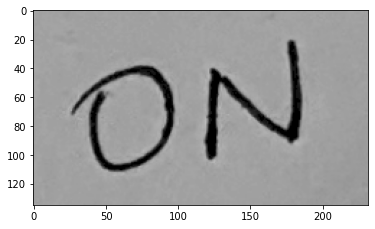

In [42]:
img, boxes = segment_img()
plt.imshow(img)
plt.show()

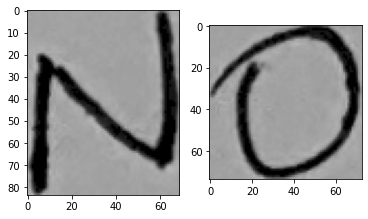

In [43]:
f, axxarr = plt.subplots(nrows=1, ncols=2)

img1 = img[boxes[0][1]:boxes[0][1] + boxes[0][3], boxes[0][0]:boxes[0][0] + boxes[0][2]]
img2 = img[boxes[1][1]:boxes[1][1] + boxes[1][3], boxes[1][0]:boxes[1][0] + boxes[1][2]]

plt.sca(axxarr[0])
plt.imshow(img1)
plt.sca(axxarr[1])
plt.imshow(img2)

plt.show()

In [46]:
img1_tensor = torch.from_numpy(img1).permute(2, 0, 1)
img2_tensor = torch.from_numpy(img2).permute(2, 0, 1)

resized_img1 = F.pad(img1_tensor, padding=5, padding_mode="edge")
resized_img1 = F.resize(resized_img1, (28, 28))
resized_img1 = F.rgb_to_grayscale(resized_img1)
resized_img1 = resized_img1 / 255.0
resized_img1 = resized_img1.unsqueeze(dim=0)

resized_img2 = F.pad(img2_tensor, padding=5, padding_mode="edge")
resized_img2 = F.resize(resized_img2, (28, 28))
resized_img2 = F.rgb_to_grayscale(resized_img2)
resized_img2 = resized_img2 / 255.0
resized_img2 = resized_img2.unsqueeze(dim=0)


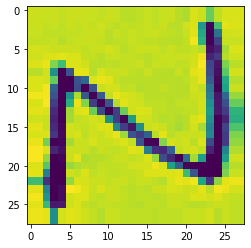

character detected: n


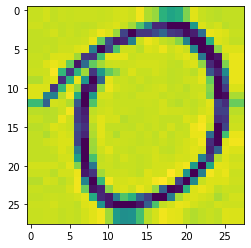

character detected: o


In [51]:
with torch.no_grad():
    model.eval()
    res1 = model(resized_img1)
    res2 = model(resized_img2)

    plt.imshow(resized_img1[0].permute(1, 2, 0))
    plt.show()
    print(f"character detected: {chr(ord('a') + res1.argmax(axis=1))}")

    plt.imshow(resized_img2[0].permute(1, 2, 0))
    plt.show()
    print(f"character detected: {chr(ord('a') + res2.argmax(axis=1))}")

#res1